In [1]:

#import libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import initializers
from keras.utils.generic_utils import get_custom_objects

import pandas as pd

In [2]:
# define error activation function
def custom_activation(x):
    
    return tf.math.erf(x/(tf.sqrt(2.*N)))
    
get_custom_objects().update({'custom_activation': Activation(custom_activation)})

#define teacher neural network 

def teacher_SCM(N,M):
"""
In: N: input-layer size
    M: hidden-layer size
       
Out:  teacher neural network -> tensorflow model

"""
    teacher=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0"),

    

    tf.keras.layers.Dense(M,activation=custom_activation,name="layer1",use_bias=False,kernel_initializer=initializers.RandomNormal(mean=0,stddev=1))])

    out=tf.keras.layers.Dense(1, activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=0,mean=1))
    out.trainable=False
    teacher.add(out)
    teacher.compile(
        optimizer=tf.keras.optimizers.SGD(1),
        loss=my_loss_fn,
        metrics=None,
   
    )
    
    new_weights=np.zeros((N,M))
    
    for i in range(0,M):
    
       new_weights[:,i]=teacher.weights[0].numpy()[:,i]/np.linalg.norm(teacher.weights[0].numpy()[:,i])*np.sqrt(N)


    b=[]
    
    b.append(new_weights)
    b.append(teacher.weights[1].numpy())

    
    teacher.set_weights(b)
    
    return teacher



def student_out(N,K,M):
    
"""
In: N: input-layer size
    K: hidden-layer size of student
    M: hidden-layer size of teacher (here not necessary)
       
Out:  student neural network -> tensorflow model

"""
    
    #,seed=13
    student=tf.keras.models.Sequential([
                                  
    tf.keras.layers.Flatten(input_shape=(N,),name="layer0")])
    
    hidden=tf.keras.layers.Dense(K,activation=custom_activation,name="layer1",use_bias=False,
    bias_initializer=initializers.Zeros(),
    kernel_initializer=initializers.random_normal(stddev=1.,mean=0))
    hidden1=tf.keras.layers.Dense(K,activation=custom_activation,name="layer1",
                use_bias=False,kernel_initializer=initializers.orthogonal(gain=np.sqrt(N),seed=None))
    hidden.trainable=False
    hidden1.trainable=False
    student.add(hidden)
    out=tf.keras.layers.Dense(1, 
    activation=None,name="layerout",use_bias=False,kernel_initializer=initializers.RandomNormal(stddev=1/np.sqrt(K),mean=0))
    out.trainable=True
    student.add(out)
    student.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=my_loss_fn,
        metrics=None,
   
    )
    
    # normalize student vectors at initialization
    
    new_weights=np.zeros((N,K))
    
    for i in range(0,K):
    
       new_weights[:,i]=student.weights[0].numpy()[:,i]/np.linalg.norm(student.weights[0].numpy()[:,i])*np.sqrt(N)


    b=[]
    
    b.append(new_weights)
    b.append(student.weights[1].numpy())

    
    student.set_weights(b)

    return student

In [3]:

#define mean-squared-error
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true- y_pred)
    return 1/2*tf.reduce_mean(squared_difference)  

#define one-pass stochastic gradient descent in the student teacher framework
def online_(student,teacher,N,p,var):
    """
In: student: tensorflow model "student"
    teacher: tensorflow model "teacher"
    
    N: input-layer size   
    p: defines the number of training data presented in once and in a sequential order
Out:  np.array(error_test): generalization error
    np.array(train): loss error
    np.array(w):weights of the student

"""
    

    np.random.seed(None)
    x_test=np.random.normal(loc=0,scale=1,size=(5000,N))
    noise_test=np.random.normal(loc=0.,scale=np.sqrt(var),size=len(x_test)).astype('float32')
    train=[]
    error_test=[]
    end=int(p/(K))
    w=[]
    
    for alpha in range(0,end):
        # use K examples at once for one step
        # this is our defined resolution alpha=p/K for the ultra-wide limit
        x_train=np.random.normal(loc=0,scale=1,size=(K,N))
        
        #create test and train labels by teacher neural network
        #with noise if necessary
        noise_train=np.random.normal(loc=0,scale=np.sqrt(var),size=len(x_train)).astype('float32')
        labels=teacher(x_train)+tf.reshape(tf.convert_to_tensor(noise_train),(len(x_train),1))
        
        labels_test=teacher(x_test)+tf.reshape(tf.convert_to_tensor(noise_test),(len(x_test),1))
        error_test.append(np.mean(teacher.loss(labels_test,student(x_test))))
        
        w.append(student.weights[1].numpy()[:])
        
        # update the student
        # batch_size and epochs correspond to one-pass algorithm
        history =student.fit(
           x=x_train,
            y=labels,
            epochs = 1,
            batch_size=1,
            verbose = 0,
            use_multiprocessing=True)
      
        
        
        train.append(history.history["loss"])
        
        # print generalization error at initialization and after every 1000 steps
        if not alpha%1000:
            print(alpha)
            print(error_test[alpha])
        
    return np.array(error_test),np.array(train), np.array(w)

In [4]:
#define the variables

N=5
K=7
M=1

In [8]:
#

R=[]
teacher=teacher_SCM(N,M)
student=student_out(N,K,M)
for i in range(K):
        
    R.append((student.weights[0].numpy()[:,i]@teacher.weights[0].numpy()[:,0])/N)
Rmax=np.max(abs(np.array(R)))
Rmax

0.6839946746826172

In [90]:
"""
We initialize the student artificially and set the teacher in such a way that the
first component of R is the largest one and the other are small and
of similar size

"""
students=[]
k=23
#
for a in [0.001,0.005,0.01,0.03,0.05,0.07,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8,0.9,1]:
    k=k+1
    student=student=student_out(N,K,M,seed=1)
    
    
    
    #define the teacher
    b=[]
    B=np.array([[np.sqrt(5),0.001,0.005,0.003,0.002]])
    
    b.append(B.T)
    b.append(teacher.weights[1].numpy())

    
    teacher.set_weights(b)
    
    #rescale the teacher
    new_weights2=np.zeros((N,M))
    for i in range(0,M):
    
        new_weights2[:,i]=teacher.weights[0].numpy()[:,i]/np.linalg.norm(teacher.weights[0].numpy()[:,i])*np.sqrt(N)

    b=[]
    b.append(new_weights2)
    b.append(teacher.weights[1].numpy())

    
    teacher.set_weights(b)



    #student
    new_weights=np.zeros((N,K))

    b=[]
       
    J=np.zeros((K,N))
    for i in range(K):
        np.random.seed(None)
        
        p=np.random.normal(0,0.1)
        # set student vector for large overlap with the teacher vector
        if i==0:
            J[i]=B-np.array([2*a,3*a,5*a,3*a,a])
            
        # set student vectors for small overlap with the teacher vector
        else:
            J[i]=np.array([0.2*p,3*p,-5*p,-3*p,p]) # for random outcome use p
      
    b.append(J.T)
    b.append(student.weights[1].numpy())

    
    student.set_weights(b)
    # rescale student vectors to have norm sqrt(N)
    new_weights2=np.zeros((N,K))
    for i in range(0,K):
    
        new_weights2[:,i]=student.weights[0].numpy()[:,i]/np.linalg.norm(student.weights[0].numpy()[:,i])*np.sqrt(N)

    b=[]
    b.append(new_weights2)
    b.append(student.weights[1].numpy())

    
    student.set_weights(b)
    
    students.append(student)


In [92]:
#show maximum overlap

R2=[]
for student in students:
    RR=[]
    for j in range(K):
        RR.append(student.weights[0].numpy()[:,j]@teacher.weights[0].numpy()[:,0]/N)
    R2.append(np.max(abs(np.array(RR))))
    
R2=np.array(R2)
R2

array([0.9999958 , 0.99988928, 0.99955311, 0.99584942, 0.98816881,
       0.97634153, 0.95080891, 0.88931723, 0.81024752, 0.72252402,
       0.63416481, 0.55057006, 0.47449636, 0.4068131 , 0.34730408,
       0.2497298 , 0.17483985, 0.11653107, 0.07029916, 0.03297004])

In [94]:
end=1000
multi_err30=[]
R=[]
for student in students:
    e=[]
    error=[]       
        
    RR=[]
    for j in range(K):
        RR.append(student.weights[0].numpy()[:,j]@teacher.weights[0].numpy()[:,0]/N)
    R.append(np.array(RR))
    print(RR)
    
    # train neural network based on the artificial iniitialization
    f=online_(student,teacher,N,K*end,0.0)
    h=f[0]
    e.append(f[1])
    error.append(h)
    print(K)
        
    multi_err30.append(np.array(error))
    print(i,flush=True)

[0.9999958038330078, 0.028183043003082275, 0.0281830370426178, 0.028183043003082275, 0.028183043003082275, 0.028183040022850037, -0.028183040022850037]
0
0.14706366
7
6
[0.9998892784118653, -0.028183040022850037, -0.028183043003082275, 0.028183043003082275, 0.028183040022850037, -0.028183043003082275, -0.028183040022850037]
0
0.577973
7
6
[0.999553108215332, -0.028183040022850037, -0.028183043003082275, 0.028183040022850037, -0.028183043003082275, 0.028183040022850037, -0.028183043003082275]
0
0.21484287
7
6
[0.9958494186401368, -0.028183040022850037, -0.028183043003082275, -0.028183043003082275, -0.028183040022850037, -0.028183043003082275, -0.028183040022850037]
0
0.121769994
7
6
[0.9881688117980957, -0.028183040022850037, -0.028183043003082275, -0.028183040022850037, -0.028183043003082275, -0.028183040022850037, -0.028183040022850037]
0
0.121356115
7
6
[0.9763415336608887, 0.0281830370426178, -0.028183040022850037, -0.028183040022850037, 0.028183040022850037, -0.0281830370426178, 0.

In [102]:
# define the mean value of the plateau (average out the fluctuations when on the plateau phase)
# plateau is reached after alpha=200

eg2=np.array(multi_err30)[:,0,:]
std=np.std(eg2[:,200:],axis=1)
eg6=np.mean(eg2[:,200:],axis=1)
eg6

#save dataframe for later
dfe=pd.DataFrame(eg6)
dfs=pd.DataFrame(std)
#dfe.to_csv("eg_von_R_1_mean.csv",sep=";",header=False)
#dfs.to_csv("eg_von_R_1_std.csv",sep=";",header=False)

In [50]:
#dfe=pd.read_csv("eg_von_R_1_mean.csv",sep=";",header=None)
#dfs=pd.read_csv("eg_von_R_1_std.csv",sep=";",header=None)

In [19]:
#read dataframe
#df=pd.read_csv("C:\\Users\\...\\eg_von_R_1.csv",sep=";",header=None)

In [96]:
# define function based on eq. 13

def func1(R):
    return 1/(2*np.pi)*(-1*R**2+np.pi/3)

def func2(R):
    return (-6/np.pi**2*np.arcsin(R/2)**2+1/6)

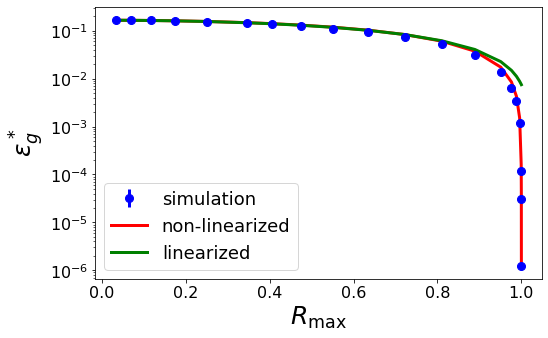

In [120]:
plt.figure(figsize=(8,5))
plt.xlabel(r"$R_{\mathrm{max}}$",size=25)
plt.ylabel(r"$\epsilon_g^*$",size=25)
plt.yscale("log")
plt.errorbar(R2[:],eg6,std,linewidth=3,fmt='o',markersize=8,color="b",zorder=10)

plt.errorbar(R2[:],func2(R2[:]),linewidth=3,zorder=2,color="r")
plt.errorbar(R2[:],func1(R2[:]),linewidth=3,zorder=3,color="green")

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([r"simulation","non-linearized","linearized","asymptotic plateau"],fontsize=18)
#plt.savefig("eps_von_R_K7_M1_N5_3.pdf",bbox_inches="tight")
plt.show();